In [1]:
import cooler
import cooltools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import product

In [2]:
# Define the resolution to use
resolution = 200  # Adjust as needed
flank = 2000
# List of .mcool files
cooler_files = {
    "larval_brain": "/Users/xl5525/Documents/mcool/larval_brain_merge.mcool",
    "cg11504": "/Users/xl5525/Documents/mcool/cg11504.merged.mcool",
    "poz": "/Users/xl5525/Documents/mcool/POZ_larval_brain_merge.mcool"
}

# Corresponding .bedpe files
bedpe_files = [
    "all_unchanged_loops_3200.bedpe",
    "cg11504_sig_loop_list_p0.05_3200.bedpe",
    "annotated_cg11504_p0.05_increased_3200.bedpe",
    "poz_sig_loop_list_p0.05_3200.bedpe",
    "poz_sig_loop_list_p0.05_increased_3200.bedpe",   
]


In [3]:
# Dictionary to store coverage for each sample
coverages = {}

# Iterate over the cooler files and compute coverage
for label, path in cooler_files.items():
    # Load the cooler at the specified resolution
    clr = cooler.Cooler(f"{path}::/resolutions/{resolution}")
    
    # Get the pixels table (raw contact counts)
    pixels = clr.pixels()[:]
    
    # Sum the 'count' column to get the total coverage
    coverage = pixels['count'].sum()
    coverages[label] = coverage
    print(f"{label} coverage: {coverage}")

# Calculate and print the coverage ratios relative to larval_brain
larval_brain_cov = coverages["larval_brain"]
for label, cov in coverages.items():
    ratio = cov / larval_brain_cov
    print(f"Coverage ratio ({label} / larval_brain): {ratio:.3f}")

larval_brain coverage: 271564227
cg11504 coverage: 175268099
poz coverage: 191966457
Coverage ratio (larval_brain / larval_brain): 1.000
Coverage ratio (cg11504 / larval_brain): 0.645
Coverage ratio (poz / larval_brain): 0.707


In [4]:
scale_factors = { label: np.sqrt(larval_brain_cov / cov) for label, cov in coverages.items() }
print("Scaling factors (sqrt):", scale_factors)

Scaling factors (sqrt): {'larval_brain': 1.0, 'cg11504': 1.2447577585196299, 'poz': 1.1893881445433327}


In [5]:
def get_average_pileup(mcool_path, bedpe_path, resolution, flank):
    """
    Load a cooler file and a BEDPE file, compute the pileup,
    and return the average pileup matrix.
    """
    # Load the cooler file at the specified resolution
    clr = cooler.Cooler(f'{mcool_path}::/resolutions/{resolution}')
    
    # Load the BEDPE file
    loops = pd.read_csv(bedpe_path, sep='\t', header=None)
    
    # Define required column names for BEDPE (first 6 columns)
    required_columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    total_columns = loops.shape[1]
    if total_columns > 6:
        extra_columns = [f'extra_col_{i}' for i in range(1, total_columns - 5)]
        column_names = required_columns + extra_columns
    else:
        column_names = required_columns
    
    loops.columns = column_names
    loops_bedpe = loops[required_columns]
    
    # Compute the pileup (this returns a 3D array: n_loops x size x size)
    pileup_result = cooltools.pileup(clr, loops_bedpe, flank=flank)
    
    # Compute and return the average 2D pileup matrix
    avg_pileup = np.nanmean(pileup_result, axis=0)
    return avg_pileup

In [6]:
base_avg = get_average_pileup(cooler_files["larval_brain"],
                              "all_unchanged_loops_3200.bedpe",
                              resolution, flank)

# For LogNorm, vmin must be > 0; use the smallest positive value.
pos_vals = base_avg[base_avg > 0]
global_vmin = pos_vals.min() if pos_vals.size > 0 else 1e-3
global_vmax = base_avg.max() if base_avg.max() > 0 else 1.0

print(f"Global scale: vmin={global_vmin}, vmax={global_vmax}")

/Users/xl5525/miniforge3/lib/python3.10/site-packages/cooltools/api/snipping.py:368: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/Users/xl5525/miniforge3/lib/python3.10/site-packages/cooltools/api/snipping.py:371: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]


Global scale: vmin=0.0008262776344539022, vmax=0.0034848981312721222


In [7]:
avg_matrices = {}
for bedpe_path in bedpe_files:
    for cooler_label, cooler_path in cooler_files.items():
        key = (bedpe_path, cooler_label)
        avg = get_average_pileup(cooler_path, bedpe_path, resolution, flank)
        # Apply coverage normalization scaling factor for this sample
        avg_matrices[key] = avg * scale_factors[cooler_label]


/Users/xl5525/miniforge3/lib/python3.10/site-packages/cooltools/api/snipping.py:368: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/Users/xl5525/miniforge3/lib/python3.10/site-packages/cooltools/api/snipping.py:371: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/Users/xl5525/miniforge3/lib/python3.10/site-packages/cooltools/api/snipping.py:368: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1

/var/folders/_4/bzgfxrd950b7snl2xdnm5d1h0000gn/T/ipykernel_49166/3535066360.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


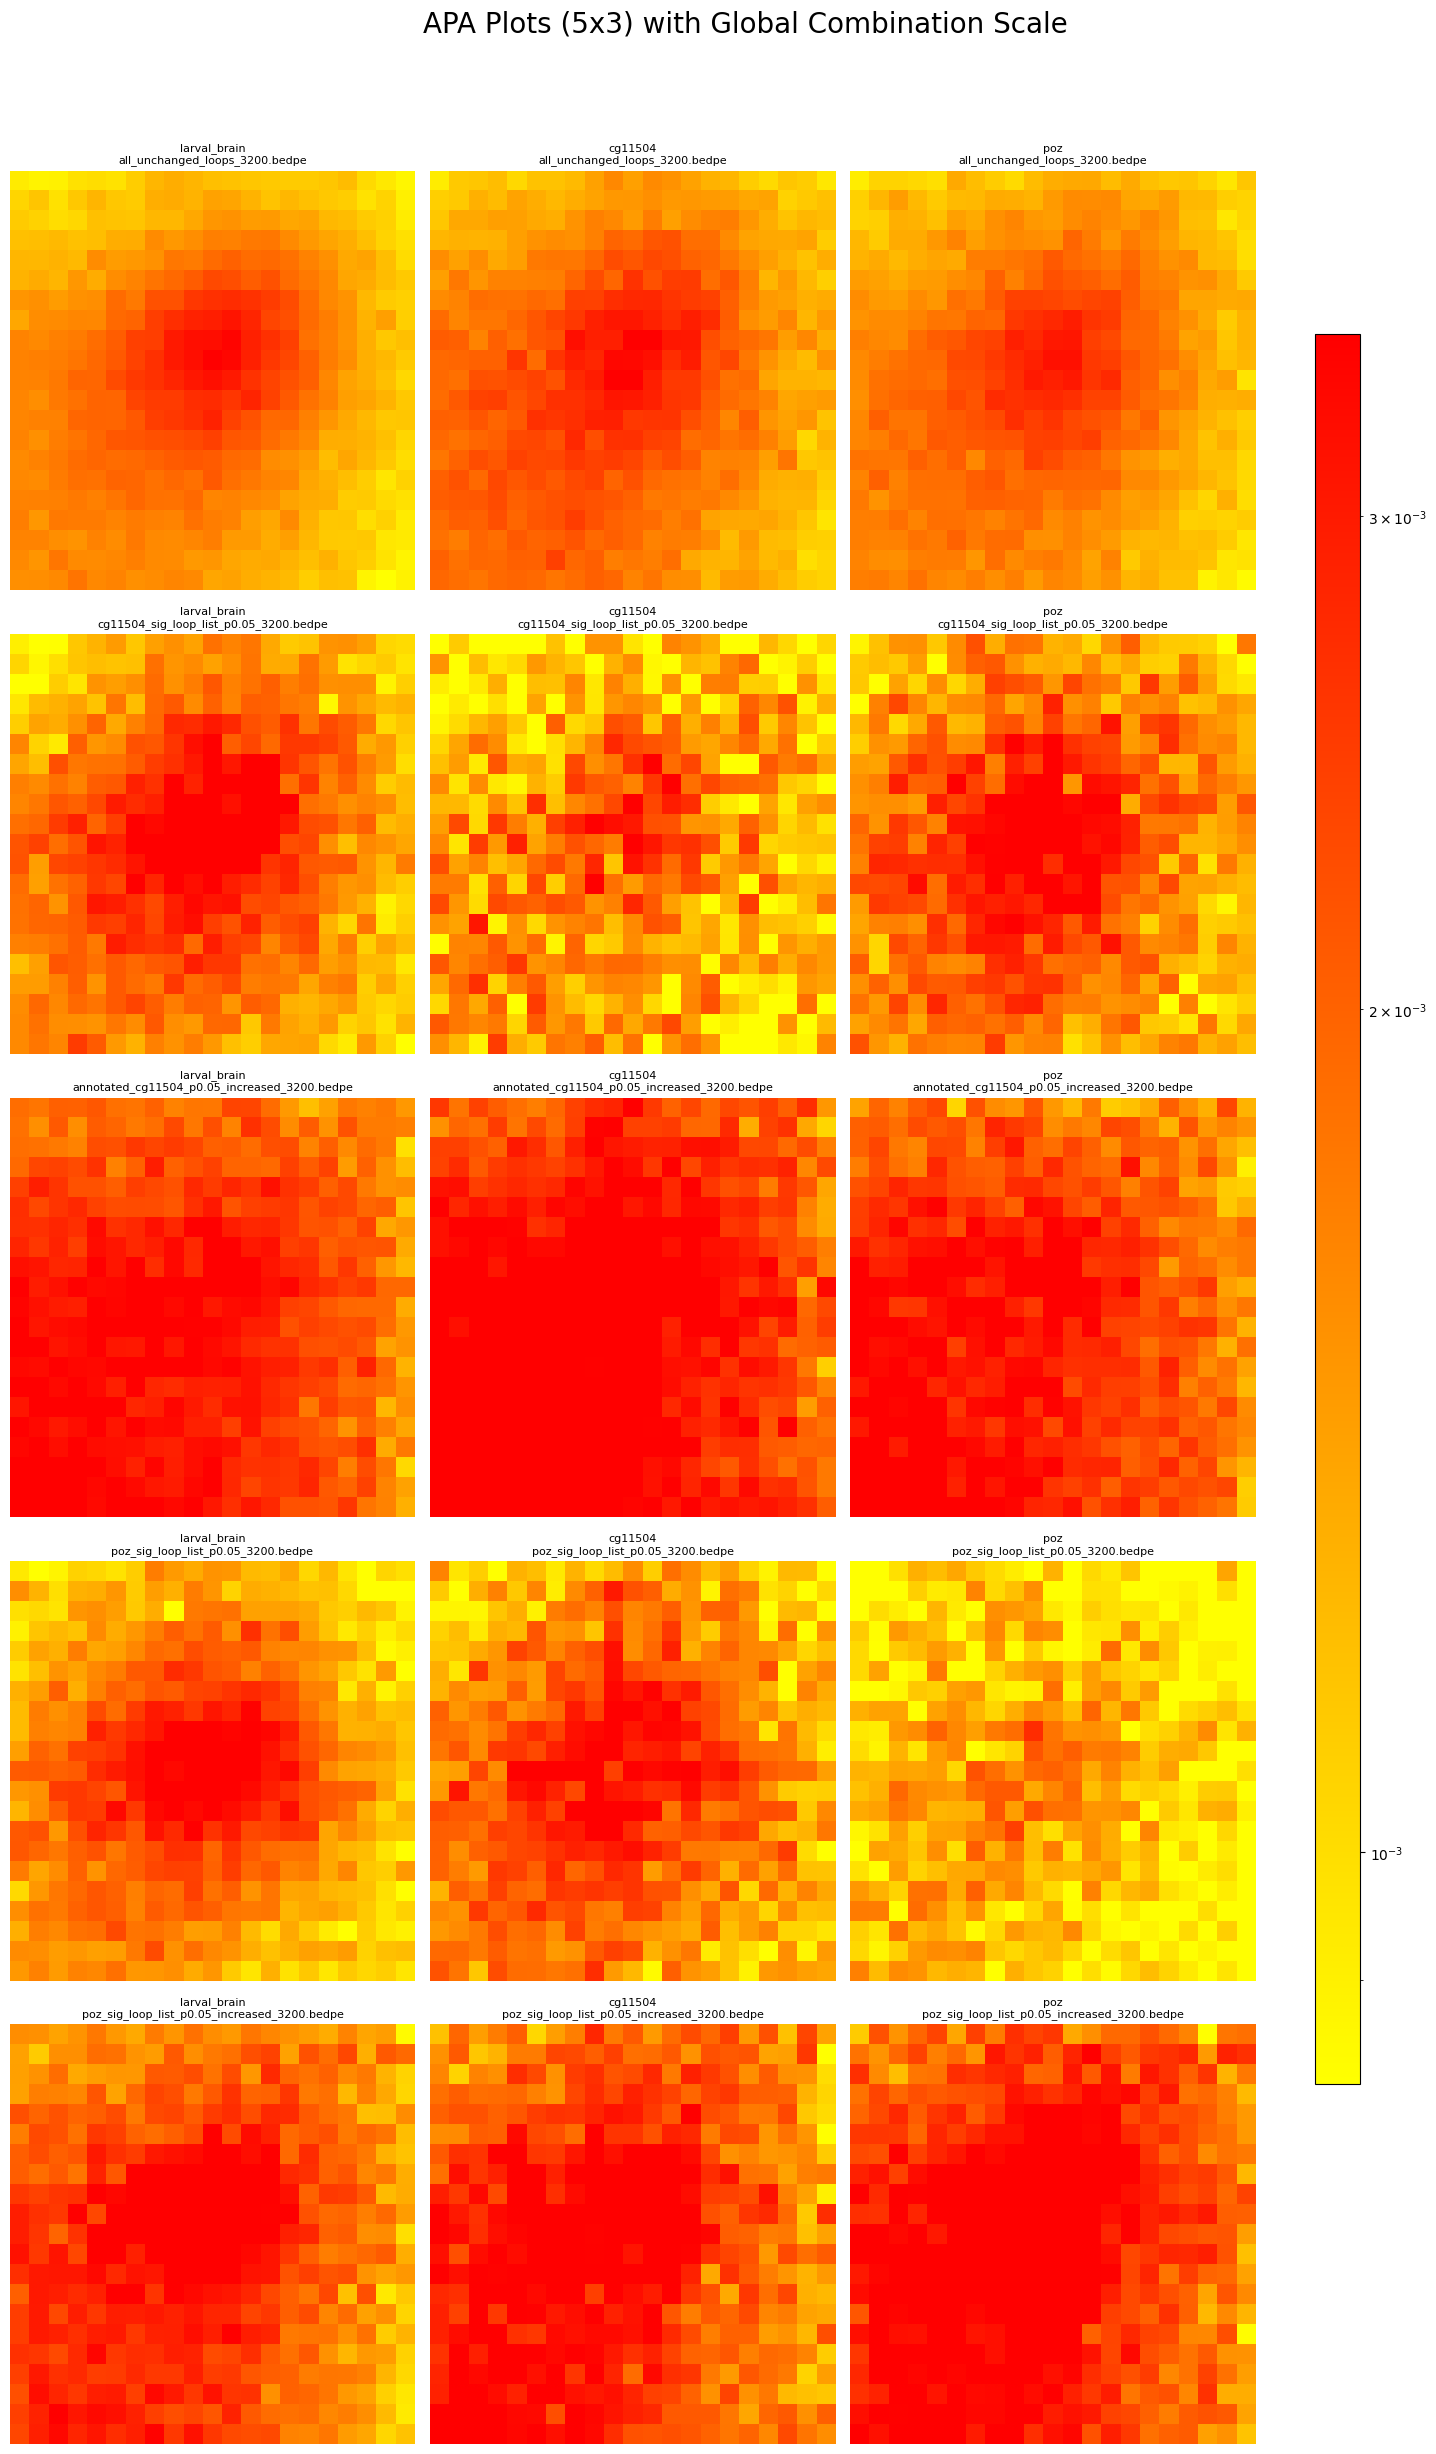

In [8]:

# -----------------------------
# Plot All Combinations in a 5x3 Figure
# -----------------------------
n_rows = len(bedpe_files)  # 5 BEDPE files
n_cols = len(cooler_files) # 3 Cooler files
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 25))

# Loop over BEDPE files (rows) and cooler files (columns)
for i, bedpe_path in enumerate(bedpe_files):
    for j, (cooler_label, _) in enumerate(cooler_files.items()):
        key = (bedpe_path, cooler_label)
        avg_pileup = avg_matrices[key]
        
        ax = axes[i, j]
        im = ax.imshow(avg_pileup, cmap='autumn_r', 
                       norm=LogNorm(vmin=global_vmin, vmax=global_vmax), aspect='auto')
        bedpe_label = bedpe_path.split('/')[-1]
        ax.set_title(f"{cooler_label}\n{bedpe_label}", fontsize=8)
        ax.axis('off')

# Add a global colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle("APA Plots (5x3) with Global Combination Scale", fontsize=20)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig("APA_5x3_global_combination_scale_normalized.png", dpi=300)
plt.show()